In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import seaborn as sns

In [2]:
# MATERIAL PROPERTY CONVERSION FORMULAS
E_from_K_and_G = lambda K, G: 9*K*G/(3*K+G)
nu_from_K_and_G = lambda K, G: (3*K-2*G)/(2*(3*K+G))
K_from_E_and_nu = lambda E, nu: E/(3*(1-2*nu))
G_from_E_and_nu = lambda E, nu: E/(2*(1+nu))
c = lambda mu, sigma: mu*(1-mu)/sigma - 1
a = lambda mu, sigma: mu*c(mu, sigma)
b = lambda mu, sigma: (1-mu)*c(mu, sigma)

In [3]:
print(K_from_E_and_nu(200e6, 0.38))
print(G_from_E_and_nu(200e6, 0.38))

print(K_from_E_and_nu(200e9, 0.28))
print(G_from_E_and_nu(200e9, 0.28))

277777777.7777778
72463768.11594203
151515151515.15152
78125000000.0


GENERATE INPUT DISTRIBUTIONS

In [4]:
# Distribution Parameters
np.random.seed(1)
#hard material: steel
#soft material: Epoxy Cure Resin

E_s_mean = 200e6
E_s_std = E_s_mean*0.08
E_s_a = E_s_mean**2/E_s_std**2
E_s_b = E_s_std**2/E_s_mean

E_h_mean = 200e9
E_h_std = E_h_mean*0.02
E_h_a = E_h_mean**2/E_h_std**2
E_h_b = E_h_std**2/E_h_mean

rho_s_mean = 1e3
rho_s_std = rho_s_mean*0.08
rho_s_a = rho_s_mean**2/rho_s_std**2
rho_s_b = rho_s_std**2/rho_s_mean

rho_h_mean = 8e3
rho_h_std = rho_h_mean*0.02
rho_h_a = rho_h_mean**2/rho_h_std**2
rho_h_b = rho_h_std**2/rho_h_mean

pr_s_mean = 0.38
pr_s_std = pr_s_mean*0.02
pr_s_a = pr_s_mean**2/pr_s_std**2
pr_s_b = pr_s_std**2/pr_s_mean

pr_h_mean = 0.28
pr_h_std = pr_h_mean*0.02
pr_h_a = pr_h_mean**2/pr_h_std**2
pr_h_b = pr_h_std**2/pr_h_mean

K_s_mean = K_from_E_and_nu(E_s_mean, pr_s_mean)
K_s_std = K_s_mean*0.08
K_s_a = K_s_mean**2/K_s_std**2
K_s_b = K_s_std**2/K_s_mean

K_h_mean = K_from_E_and_nu(E_h_mean, pr_h_mean)
#K_h_mean = 150e9
K_h_std = K_h_mean*0.02
K_h_a = K_h_mean**2/K_h_std**2
K_h_b = K_h_std**2/K_h_mean

G_s_mean = G_from_E_and_nu(E_s_mean, pr_s_mean)
G_s_std = G_s_mean*0.08
G_s_a = G_s_mean**2/G_s_std**2
G_s_b = G_s_std**2/G_s_mean

G_h_mean = G_from_E_and_nu(E_h_mean, pr_h_mean)
#G_h_mean = 78e9
G_h_std = G_h_mean*0.02
G_h_a = G_h_mean**2/G_h_std**2
G_h_b = G_h_std**2/G_h_mean

geo_fp_mean = 0.025
geo_fp_std = geo_fp_mean*0.08
geo_fp_var = geo_fp_std**2
geo_fp_a = a(geo_fp_mean, geo_fp_var)
geo_fp_b = b(geo_fp_mean, geo_fp_var)

In [5]:
#Create Gaussian Distributions
# E_soft_dist = cp.Normal(E_s_mean, E_s_std)
# E_hard_dist = cp.Normal(E_h_mean, E_h_std)
# rho_soft_dist = cp.Normal(rho_s_mean, rho_s_std)
# rho_hard_dist = cp.Normal(rho_h_mean, rho_h_std)
# pr_soft_dist = cp.Normal(pr_s_mean, pr_s_std)
# pr_hard_dist = cp.Normal(pr_h_mean, pr_h_std)
# geo_fp_dist = cp.Normal(geo_fp_mean, geo_fp_std)
# joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist, geo_fp_dist)

In [6]:
#Create Gamma Distributions
# E_soft_dist = cp.Gamma(E_s_a, E_s_b)
# E_hard_dist = cp.Gamma(E_h_a, E_h_b)
rho_soft_dist = cp.Gamma(rho_s_a, rho_s_b)
rho_hard_dist = cp.Gamma(rho_h_a, rho_h_b)
# pr_soft_dist = cp.Gamma(pr_s_a, pr_s_b)
# pr_hard_dist = cp.Gamma(pr_h_a, pr_h_b)
K_soft_dist = cp.Gamma(K_s_a, K_s_b)
K_hard_dist = cp.Gamma(K_h_a, K_h_b)
G_soft_dist = cp.Gamma(G_s_a, G_s_b)
G_hard_dist = cp.Gamma(G_h_a, G_h_b)
geo_fp_dist = cp.Beta(geo_fp_a, geo_fp_b)
# joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist, geo_fp_dist)
joint_dist = cp.J(rho_soft_dist, rho_hard_dist, K_soft_dist, K_hard_dist, G_soft_dist, G_hard_dist, geo_fp_dist)

Text(0.5, 0.98, 'Histograms of 100 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input')

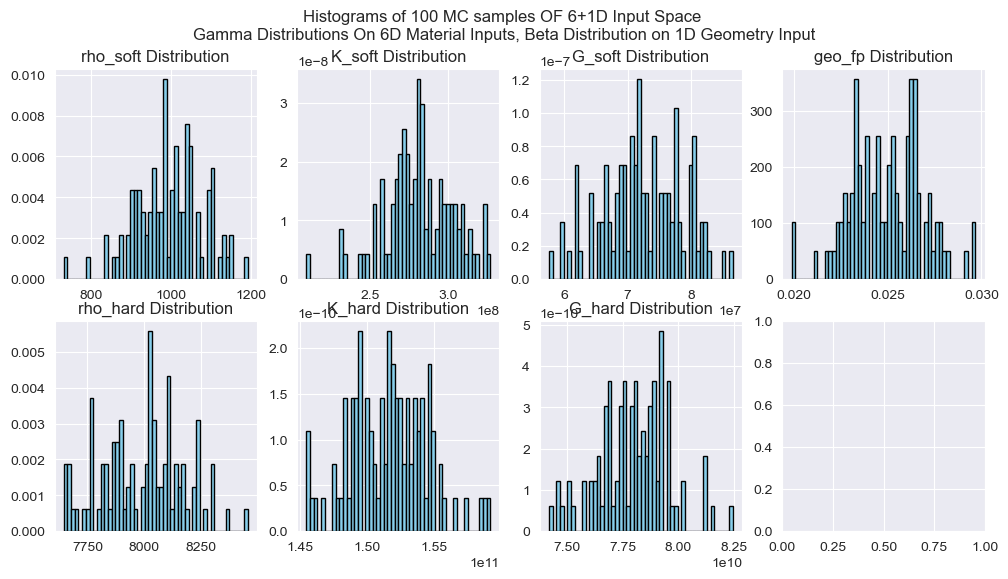

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(rho_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('rho_soft Distribution')

axes[1, 0].hist(rho_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('rho_hard Distribution')

axes[0, 1].hist(K_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('K_soft Distribution')

axes[1, 1].hist(K_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('K_hard Distribution')

axes[0, 2].hist(G_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('G_soft Distribution')

axes[1, 2].hist(G_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('G_hard Distribution')

axes[0, 3].hist(geo_fp_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp Distribution')

title_str = 'Histograms of 100 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 1000 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input')

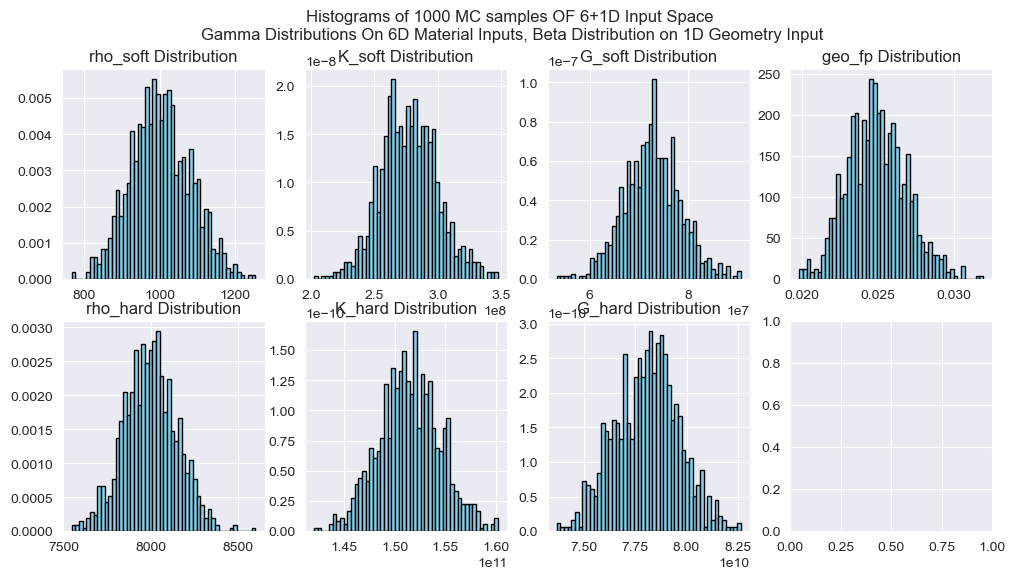

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(rho_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('rho_soft Distribution')

axes[1, 0].hist(rho_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('rho_hard Distribution')

axes[0, 1].hist(K_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('K_soft Distribution')

axes[1, 1].hist(K_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('K_hard Distribution')

axes[0, 2].hist(G_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('G_soft Distribution')

axes[1, 2].hist(G_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('G_hard Distribution')

axes[0, 3].hist(geo_fp_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp Distribution')

title_str = 'Histograms of 1000 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 10000 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input')

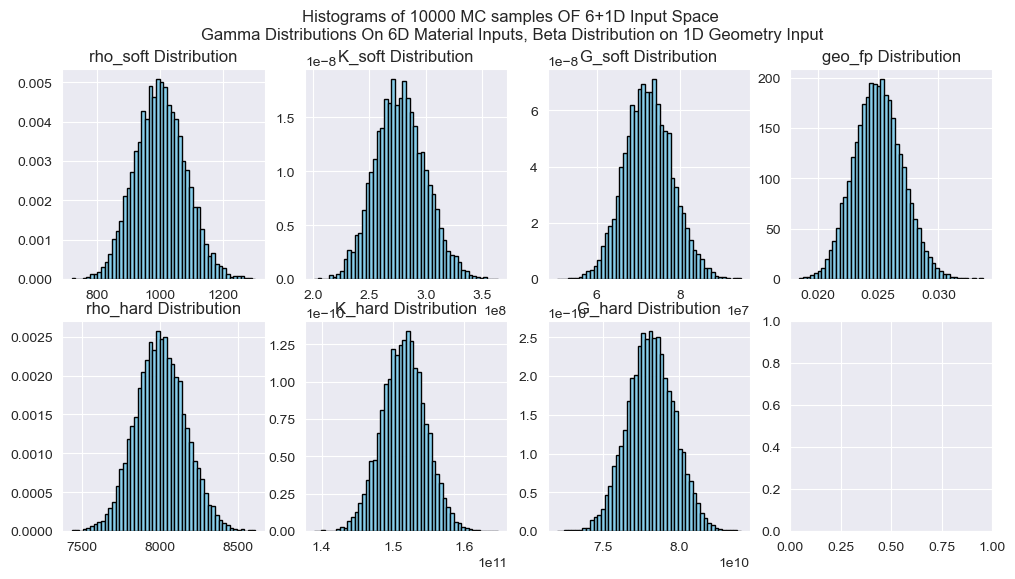

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(rho_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('rho_soft Distribution')

axes[1, 0].hist(rho_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('rho_hard Distribution')

axes[0, 1].hist(K_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('K_soft Distribution')

axes[1, 1].hist(K_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('K_hard Distribution')

axes[0, 2].hist(G_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('G_soft Distribution')

axes[1, 2].hist(G_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('G_hard Distribution')

axes[0, 3].hist(geo_fp_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp Distribution')

title_str = 'Histograms of 10000 MC samples OF 6+1D Input Space \nGamma Distributions On 6D Material Inputs, Beta Distribution on 1D Geometry Input'
fig.suptitle(title_str)

In [10]:
### GENERATE QUADRATURE RULE SAMPLES ###
degrees = [1, 2, 3]
#computation points = (degree+1)**(input dimensions)
quadrature_surrogates = {}
quadrature_nodes = {}
quadrature_weights = {}
for d in degrees:
    nodes, weights = cp.generate_quadrature(d, joint_dist, rule='G')
    quadrature_nodes[d] = nodes
    quadrature_weights[d] = weights

for qd in quadrature_nodes:
    savemat('joint_dist_mat_geo_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_nodes[qd]})
    savemat('geo_dist_beta_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_geos':quadrature_nodes[qd][6]})

print(np.mean(quadrature_nodes[1][6]))

0.025155871856926026


In [108]:
### GENERATE MONTE CARLO INPUT SAMPLES ###
N_MC2 = 200
N_MC3 = 250
N_MC4 = 300

joint_samples_MC2 = joint_dist.sample(N_MC2)
joint_samples_MC3 = joint_dist.sample(N_MC3)
joint_samples_MC4 = joint_dist.sample(N_MC4)

savemat('joint_dist_mat_geo_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_inputs':joint_samples_MC2})
savemat('joint_dist_mat_geo_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_inputs':joint_samples_MC3})
savemat('joint_dist_mat_geo_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_inputs':joint_samples_MC4})

In [109]:
print(joint_samples_MC2.shape)
print(joint_samples_MC2[-1::].shape)
geo_fp_dist_beta_MC2 = joint_samples_MC2[-1::]
geo_fp_dist_beta_MC3 = joint_samples_MC3[-1::]
geo_fp_dist_beta_MC4 = joint_samples_MC4[-1::]

savemat('geo_fp_dist_beta_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_geos':geo_fp_dist_beta_MC2})
savemat('geo_fp_dist_beta_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_geos':geo_fp_dist_beta_MC3})
savemat('geo_fp_dist_beta_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_geos':geo_fp_dist_beta_MC4})

(7, 200)
(1, 200)


QUADRATURE INPUT DISTRIBUTIONS GENERATED - MATLAB RUNS COMMENCE

In [15]:
rho_soft_sample_sets = {}
rho_hard_sample_sets = {}
K_soft_sample_sets = {}
K_hard_sample_sets = {}
G_soft_sample_sets = {}
G_hard_sample_sets = {}
E_soft_sample_sets = {}
E_hard_sample_sets = {}
pr_soft_sample_sets = {}
pr_hard_sample_sets = {}
geo_fp_sample_sets = {}
bg_size_sample_sets = {}
bg_top_sample_sets = {}
bg_bottom_sample_sets = {}
bg_center_sample_sets = {}

degrees = [1,2]
for d in degrees:
    folder_name = 'gamma beta 6+1 inputs quadrature rule study'#+str(d)
    file_suffix ='_gamma_7d_fp_5%_n'+str((d+1)**7)+'.mat'

    # rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    # rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    # K_soft_file = loadmat(folder_name+'/K_soft'+file_suffix)
    # K_hard_file = loadmat(folder_name+'/K_hard'+file_suffix)
    # G_soft_file = loadmat(folder_name+'/G_soft'+file_suffix)
    # G_hard_file = loadmat(folder_name+'/G_hard'+file_suffix)
    # E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    # E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    # pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    # pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    # rho_soft_sample_sets[d] = rho_soft_file['rho_soft'][:]
    # rho_hard_sample_sets[d] = rho_hard_file['rho_hard'][:]
    # K_soft_sample_sets[d] = K_soft_file['K_soft'][:]
    # K_hard_sample_sets[d] = K_hard_file['K_hard'][:]
    # G_soft_sample_sets[d] = G_soft_file['G_soft'][:]
    # G_hard_sample_sets[d] = G_hard_file['G_hard'][:]
    # E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    # E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    # pr_soft_sample_sets[d] = pr_soft_file['pr_soft'][:]
    # pr_hard_sample_sets[d] = pr_hard_file['pr_hard'][:]

    bg_size_sample_sets[d] = bg_size_file['bg_size'][:]
    bg_top_sample_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_sample_sets[d] = bg_bottom_file['bg_bottom'][:]
    bg_center_sample_sets[d] = (bg_top_sample_sets[d]+bg_bottom_sample_sets[d])/2

    mat_geo_dist_file = loadmat(folder_name+'/joint_dist_mat_geo_pd_'+str(d)+'.mat')
    rho_soft_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][0,:]
    rho_hard_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][1,:]
    K_soft_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][2,:]
    K_hard_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][3,:]
    G_soft_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][4,:]
    G_hard_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][5,:]
    geo_fp_sample_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][6,:]

In [16]:
rho_soft_MC_sets = {}
rho_hard_MC_sets = {}
K_soft_MC_sets = {}
K_hard_MC_sets = {}
G_soft_MC_sets = {}
G_hard_MC_sets = {}
E_soft_MC_sets = {}
E_hard_MC_sets = {}
pr_soft_MC_sets = {}
pr_hard_MC_sets = {}
geo_fp_MC_sets = {}
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}
bg_center_MC_sets = {}

set_N = [100, 1000, 10000]
for N in set_N:
    folder_name = 'gamma beta 6+1 inputs mc study'#+str(N)
    file_suffix = '_gamma_7d_fp_5%_n'+str(N)+'.mat'

    # rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    # rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    # K_soft_file = loadmat(folder_name+'/K_soft'+file_suffix)
    # K_hard_file = loadmat(folder_name+'/K_hard'+file_suffix)
    # G_soft_file = loadmat(folder_name+'/G_soft'+file_suffix)
    # G_hard_file = loadmat(folder_name+'/G_hard'+file_suffix)
    # E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    # E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    # pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    # pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    # geo_fp_file = loadmat(folder_name+'/geo_fp'+'_dist_beta_mc_'+str(N)+'.mat')

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    # E_soft_MC_sets[N] = E_soft_file['E_soft'][:]
    # E_hard_MC_sets[N] = E_hard_file['E_hard'][:]
    # rho_soft_MC_sets[N] = rho_soft_file['rho_soft'][:]
    # rho_hard_MC_sets[N] = rho_hard_file['rho_hard'][:]
    # pr_soft_MC_sets[N] = pr_soft_file['pr_soft'][:]
    # pr_hard_MC_sets[N] = pr_hard_file['pr_hard'][:]
    # geo_fp_MC_sets[N] = geo_fp_file['mc_'+str(N)+'_geos'][:].T

    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]
    bg_center_MC_sets[N] = (bg_top_MC_sets[N] + bg_bottom_MC_sets[N])/2

    mat_geo_dist_file = loadmat(folder_name+'/joint_dist_mat_geo_mc_'+str(N)+'.mat')
    rho_soft_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][0,:]
    rho_hard_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][1,:]
    K_soft_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][2,:]
    K_hard_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][3,:]
    G_soft_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][4,:]
    G_hard_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][5,:]
    geo_fp_MC_sets[N] = mat_geo_dist_file['mc_'+str(N)+'_inputs'][6,:]

In [18]:
print(type(bg_center_sample_sets))
print(len(bg_center_sample_sets[2]))

print(type(bg_center_MC_sets))
print(len(bg_center_MC_sets[10000]))

print(type(geo_fp_MC_sets))
print(len(geo_fp_MC_sets[10000]))
print(geo_fp_MC_sets[1000].shape)
print(rho_hard_MC_sets[1000].shape)
# fig = plt.figure()
# plt.scatter(E_soft_sample_sets[2], bg_size_sample_sets[2])
# plt.title('Black Box Model Evaluations on 2th order quadrature samples')
# plt.xlabel('E_soft')
# plt.ylabel('bg_size')

<class 'dict'>
2187
<class 'dict'>
10000
<class 'dict'>
10000
(1000,)
(1000,)


Quadrature fits on bandgap size

In [19]:
### FIT SURROGATE MODELS - QUADRATURE RULE ###
q_surrogates_bgs = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_size_sample_sets[degree]
    )
    q_surrogates_bgs[degree] = polynomial_approximation

In [20]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 1000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgs[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes[degree] = gaussian_kde(surrogate_outputs[degree])
    surrogate_pdf[degree] = surrogate_kdes[degree](np.linspace(np.min(surrogate_outputs[degree]), np.max(surrogate_outputs[degree]), 1000))

(7, 1000)


Text(0.5, 0.98, 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders 1 to 2 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

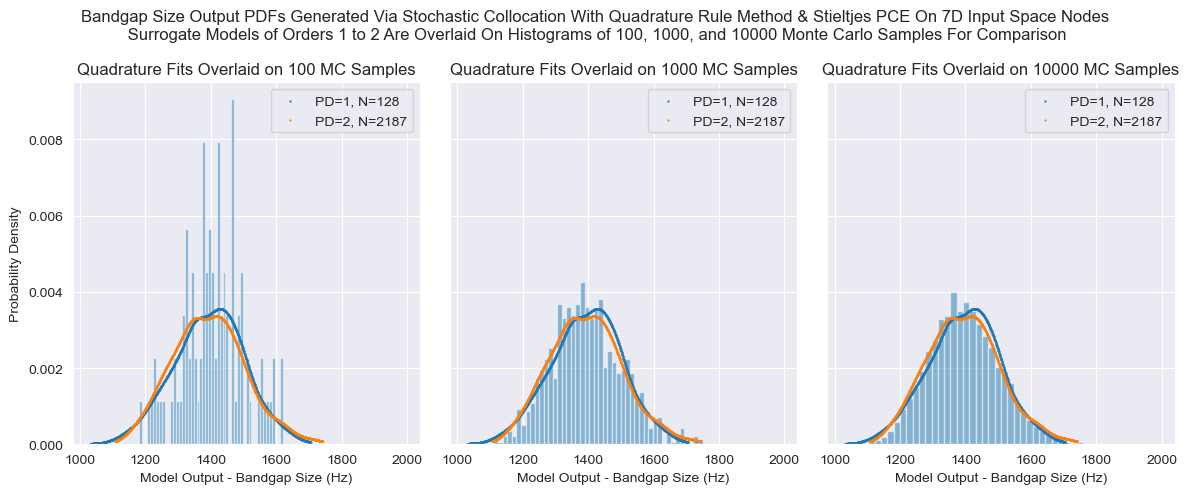

In [78]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output - Bandgap Size (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Quadrature fits on bandgap top

In [25]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP TOP ###
q_surrogates_bgt = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_top_sample_sets[degree]
    )
    q_surrogates_bgt[degree] = polynomial_approximation

In [26]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgt = 1000
joint_test_bgt = joint_dist.sample(N_test_bgt)
print(joint_test_bgt.shape)
#print(joint_test_bgt[0])
surrogate_outputs_bgt = {}
surrogate_kdes_bgt = {}
surrogate_pdf_bgt = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgt[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgt[degree] = surrogate_model.__call__(joint_test_bgt).astype(float)
    surrogate_outputs_bgt[degree] = surrogate_model(
        q0=joint_test_bgt[0,:], q1=joint_test_bgt[1,:],
        q2=joint_test_bgt[2,:], q3=joint_test_bgt[3,:],
        q4=joint_test_bgt[4,:], q5=joint_test_bgt[5,:], q6=joint_test_bgt[6,:])
    #print(surrogate_outputs_bgt[degree])
    surrogate_kdes_bgt[degree] = gaussian_kde(surrogate_outputs_bgt[degree])
    surrogate_pdf_bgt[degree] = surrogate_kdes_bgt[degree](np.linspace(np.min(surrogate_outputs_bgt[degree]), np.max(surrogate_outputs_bgt[degree]), 1000))

(7, 1000)


Text(0.5, 0.98, 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders 1 to 2 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

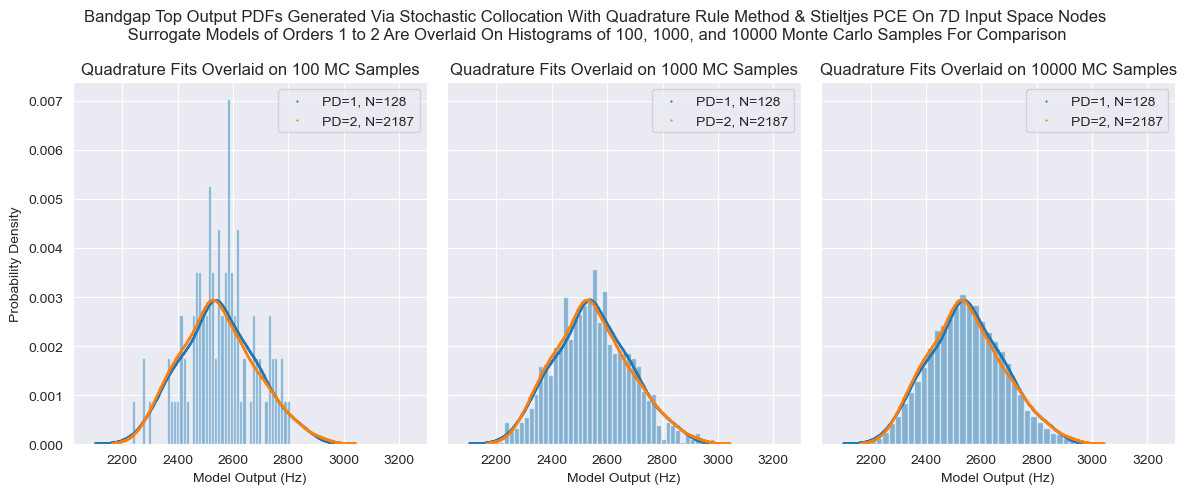

In [79]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Quadrature fits on bandgap bottom

In [29]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP BOTTOM ###
q_surrogates_bgb = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_bottom_sample_sets[degree]
    )
    q_surrogates_bgb[degree] = polynomial_approximation

In [30]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgb = 1000
joint_test_bgb = joint_dist.sample(N_test_bgb)
print(joint_test_bgb.shape)
#print(joint_test_bgb[0])
surrogate_outputs_bgb = {}
surrogate_kdes_bgb = {}
surrogate_pdf_bgb = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgb[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgb[degree] = surrogate_model.__call__(joint_test_bgb).astype(float)
    surrogate_outputs_bgb[degree] = surrogate_model(
        q0=joint_test_bgb[0,:], q1=joint_test_bgb[1,:],
        q2=joint_test_bgb[2,:], q3=joint_test_bgb[3,:],
        q4=joint_test_bgb[4,:], q5=joint_test_bgb[5,:], q6=joint_test_bgb[6,:])
    #print(surrogate_outputs_bgb[degree])
    surrogate_kdes_bgb[degree] = gaussian_kde(surrogate_outputs_bgb[degree])
    surrogate_pdf_bgb[degree] = surrogate_kdes_bgb[degree](np.linspace(np.min(surrogate_outputs_bgb[degree]), np.max(surrogate_outputs_bgb[degree]), 1000))

(7, 1000)


Text(0.5, 0.98, 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders 1 to 2 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

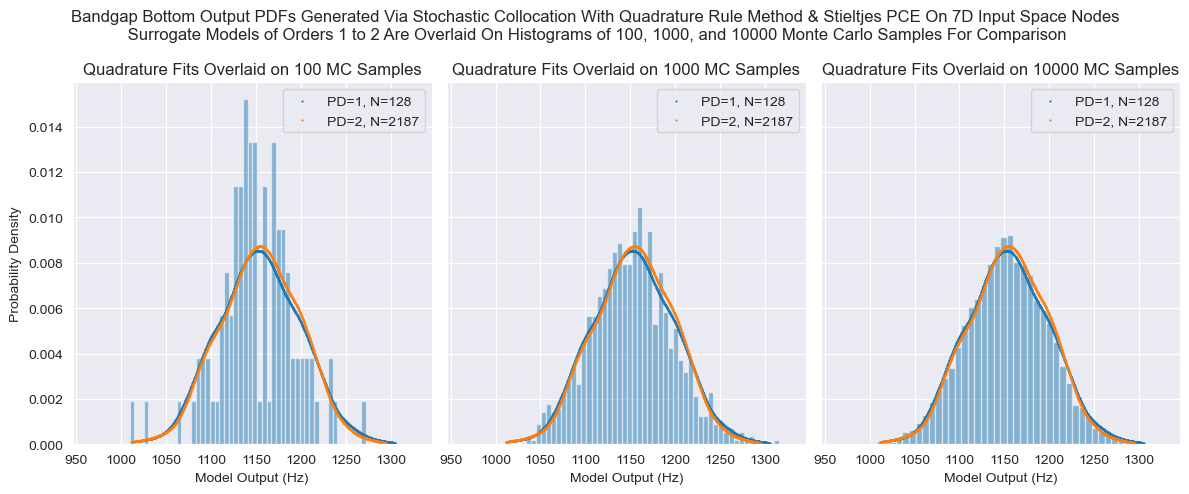

In [80]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Quadrature fits on bandgap center

In [32]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP CENTER ###
q_surrogates_bgc = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_center_sample_sets[degree]
    )
    q_surrogates_bgc[degree] = polynomial_approximation

In [34]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgc = 1000
joint_test_bgc = joint_dist.sample(N_test_bgc)
print(joint_test_bgc.shape)
#print(joint_test_bgc[0])
surrogate_outputs_bgc = {}
surrogate_kdes_bgc = {}
surrogate_pdf_bgc = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgc[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgc[degree] = surrogate_model.__call__(joint_test_bgc).astype(float)
    surrogate_outputs_bgc[degree] = surrogate_model(
        q0=joint_test_bgc[0,:], q1=joint_test_bgc[1,:],
        q2=joint_test_bgc[2,:], q3=joint_test_bgc[3,:],
        q4=joint_test_bgc[4,:], q5=joint_test_bgc[5,:], q6=joint_test_bgc[6,:])
    #print(surrogate_outputs_bgc[degree])
    surrogate_kdes_bgc[degree] = gaussian_kde(surrogate_outputs_bgc[degree])
    surrogate_pdf_bgc[degree] = surrogate_kdes_bgc[degree](np.linspace(np.min(surrogate_outputs_bgc[degree]), np.max(surrogate_outputs_bgc[degree]), 1000))

(7, 1000)


Text(0.5, 0.98, 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders 1 to 2 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

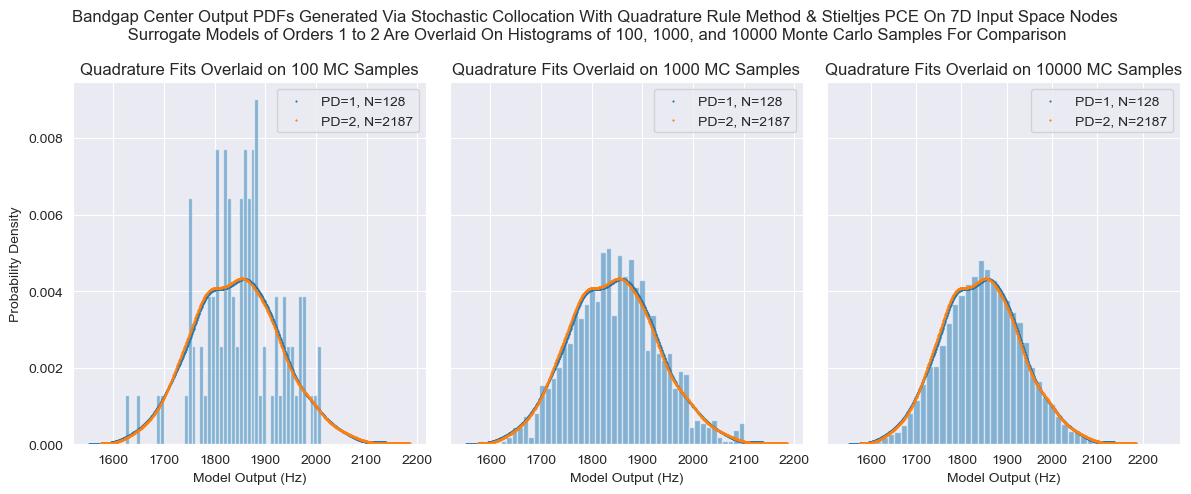

In [81]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With Quadrature Rule Method & Stieltjes PCE On 7D Input Space Nodes\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Alternative Graphs

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top, Bottom,\n and Center Locations For 7D Input Space, Gamma Distributions")

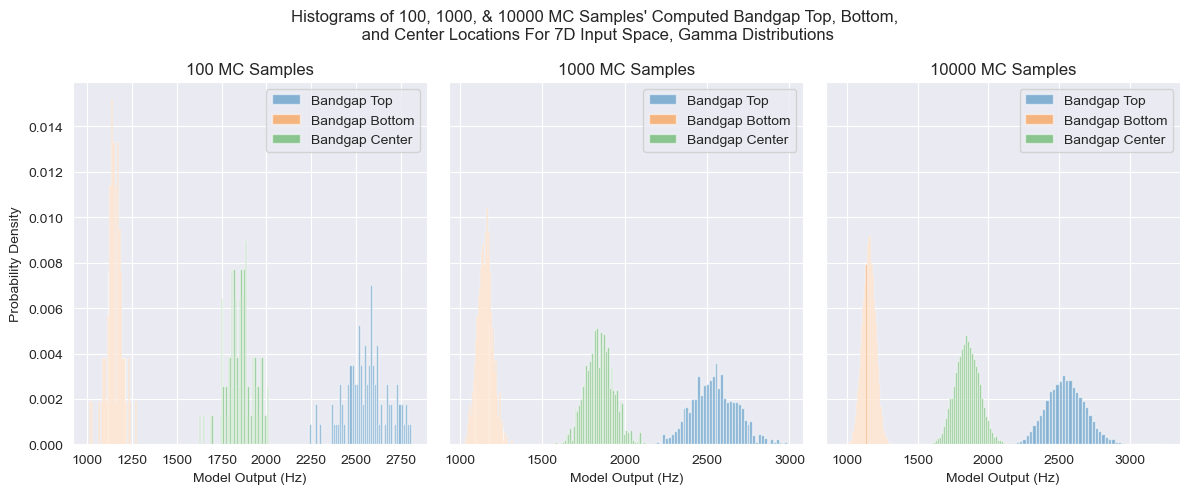

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
# axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
# axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
# axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top, Bottom,\n and Center Locations For 7D Input Space, Gamma Distributions'
fig.suptitle(title_str)


Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top and Bottom Locations\n and Bandgap Size For 7D Input Space, Gamma Distributions")

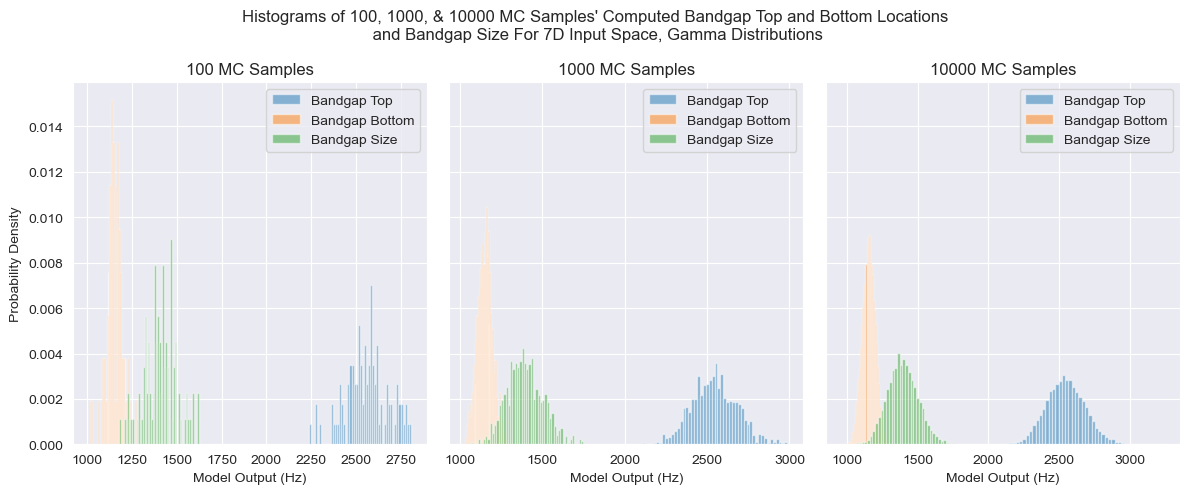

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Size')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top and Bottom Locations\n and Bandgap Size For 7D Input Space, Gamma Distributions'
fig.suptitle(title_str)

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top\n and Bottom Locations For 7D Input Space, Gamma Distributions")

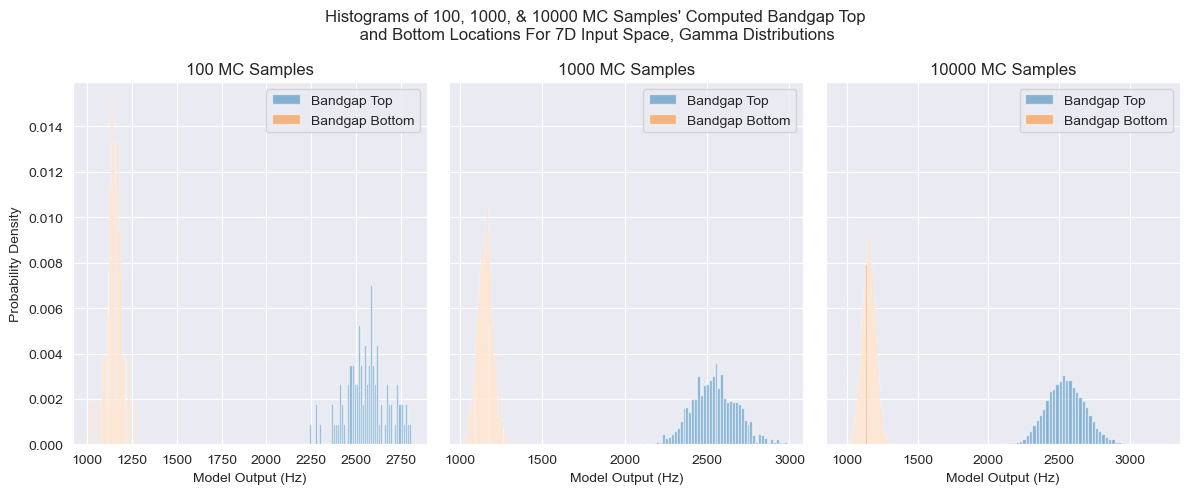

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top\n and Bottom Locations For 7D Input Space, Gamma Distributions'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Size

In [44]:
MC_inputs = {}
# MC_inputs[N_MC2] = joint_samples_MC2
# MC_inputs[N_MC3] = joint_samples_MC3
# MC_inputs[N_MC4] = joint_samples_MC4
for n in set_N:
    MC_inputs[n] = np.vstack((
        rho_soft_MC_sets[n],
        rho_hard_MC_sets[n],
        K_soft_MC_sets[n],
        K_hard_MC_sets[n],
        G_soft_MC_sets[n],
        G_hard_MC_sets[n],
        geo_fp_MC_sets[n]
    ))

MC_degrees = {}
MC_degrees[N_MC2] = np.array([1,2,3,4])
MC_degrees[N_MC3] = np.array([1,2,3,4])
MC_degrees[N_MC4] = np.array([1,2,3,4])
print(MC_inputs[N_MC2].shape)
print(MC_inputs[N_MC3].shape)
print(MC_inputs[N_MC4].shape)
print(type(MC_degrees))
print(type(MC_degrees[N_MC2]))

(7, 100)
(7, 1000)
(7, 10000)
<class 'dict'>
<class 'numpy.ndarray'>


In [45]:
# r_surrogates_bgs_MC_100 = {}
# for degree in MC_degrees[N_MC2]:
#     polynomial_basis = cp.expansion.stieltjes(
#         order=degree,
#         dist=joint_dist_trunc,
#         normed=True
#     )
#     # print(fit_input.shape)
#     # print(bg_size_MC_sets[100].shape)
#     polynomial_approximation = cp.fit_regression(
#         polynomials=polynomial_basis,
#         abscissas=MC_inputs[N_MC2],
#         evals=bg_size_MC_sets[N_MC2],
#     )
#     r_surrogates_bgs_MC_100[degree] = polynomial_approximation

In [84]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgs = {}
for n in set_N:
    print(n)
    r_surrogates_bgs[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n],
            evals=bg_size_MC_sets[n],
        )
        r_surrogates_bgs[n][degree] = polynomial_approximation

100
1000
10000


In [85]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgs[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), 1000))

Text(0.5, 0.98, 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With 100 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

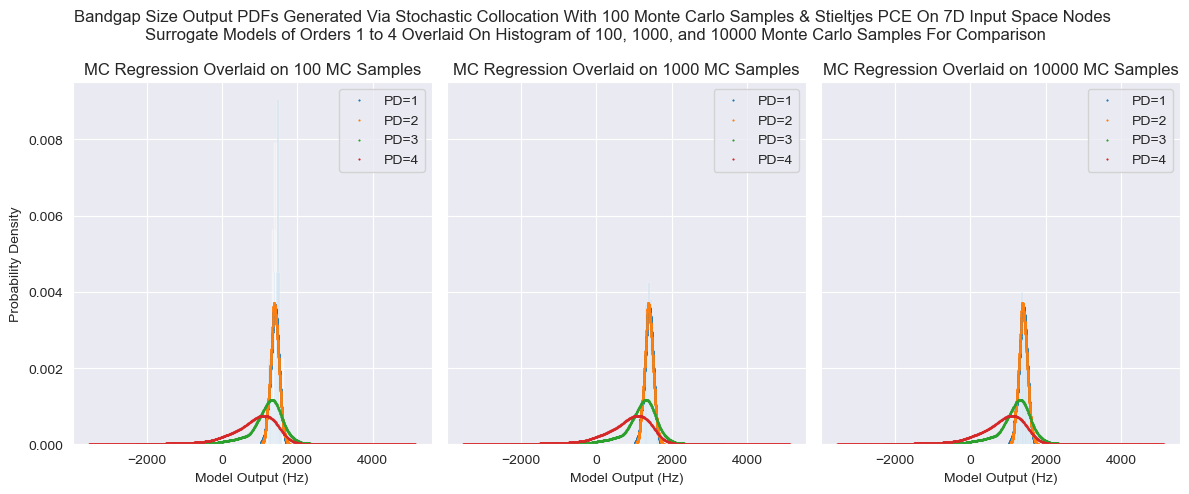

In [86]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With '+str(N_MC2)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With 1000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

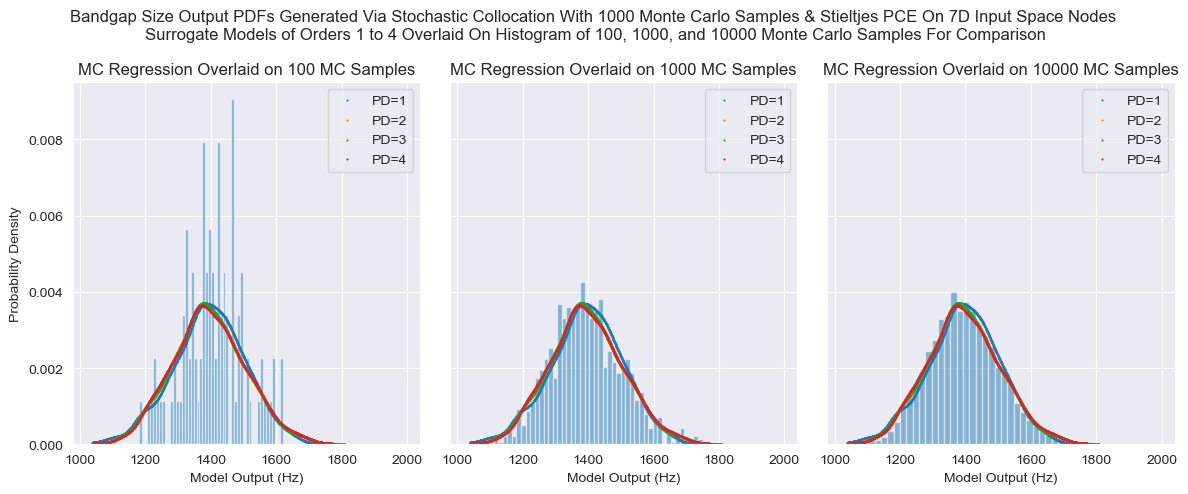

In [87]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With '+str(N_MC3)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With 10000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

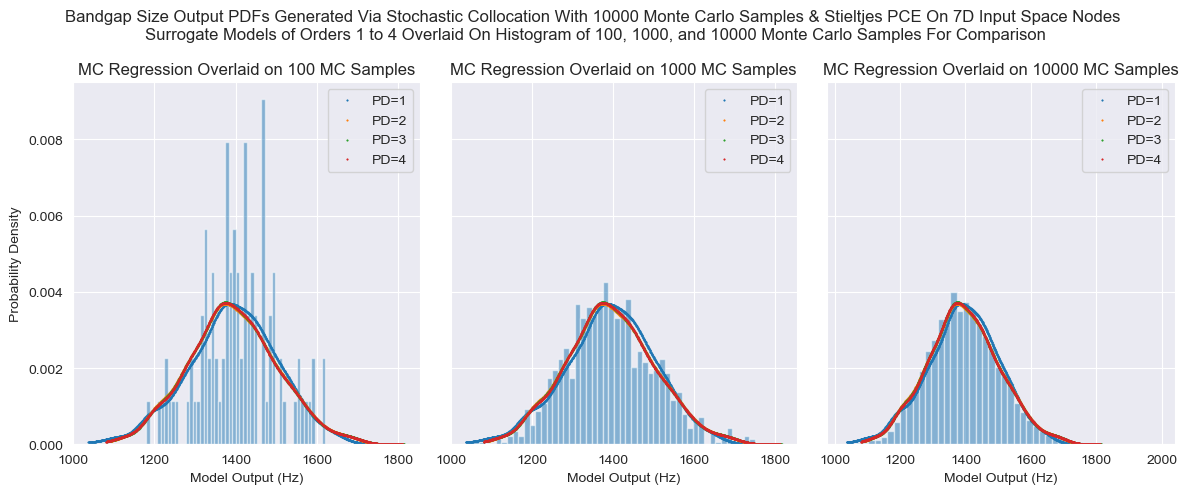

In [89]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs Generated Via Stochastic Collocation With '+str(N_MC4)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Top

In [91]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgt = {}
for n in set_N:
    print(n)
    r_surrogates_bgt[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n],
            evals=bg_top_MC_sets[n],
        )
        r_surrogates_bgt[n][degree] = polynomial_approximation

100
1000
10000


In [92]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgt[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), 1000))

Text(0.5, 0.98, 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With 100 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

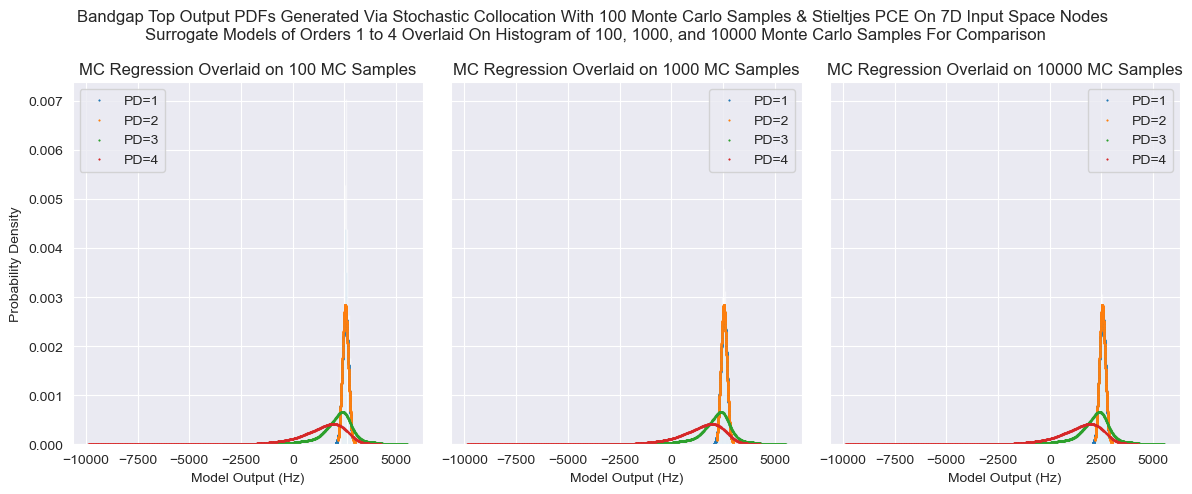

In [93]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With '+str(N_MC2)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With 1000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

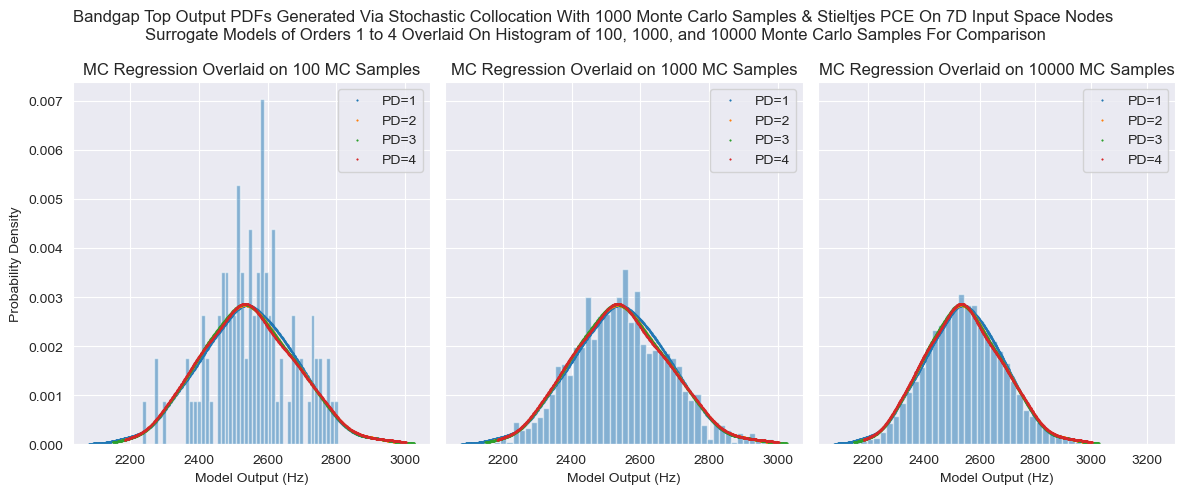

In [94]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With '+str(N_MC3)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With 10000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

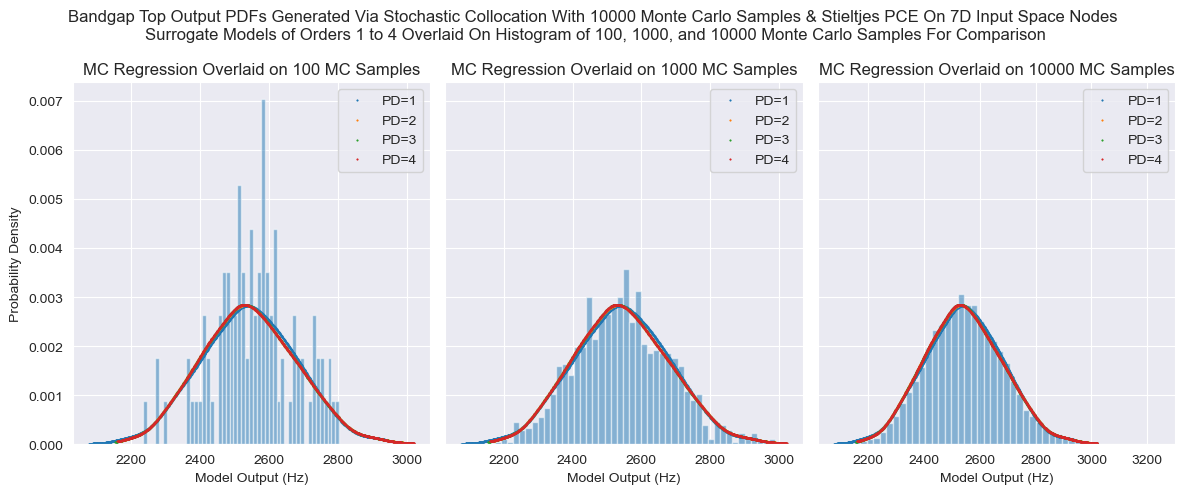

In [95]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs Generated Via Stochastic Collocation With '+str(N_MC4)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Bottom


In [96]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgb = {}
for n in set_N:
    print(n)
    r_surrogates_bgb[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n],
            evals=bg_bottom_MC_sets[n],
        )
        r_surrogates_bgb[n][degree] = polynomial_approximation

100
1000
10000


In [97]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgb[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), 1000))

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With 100 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

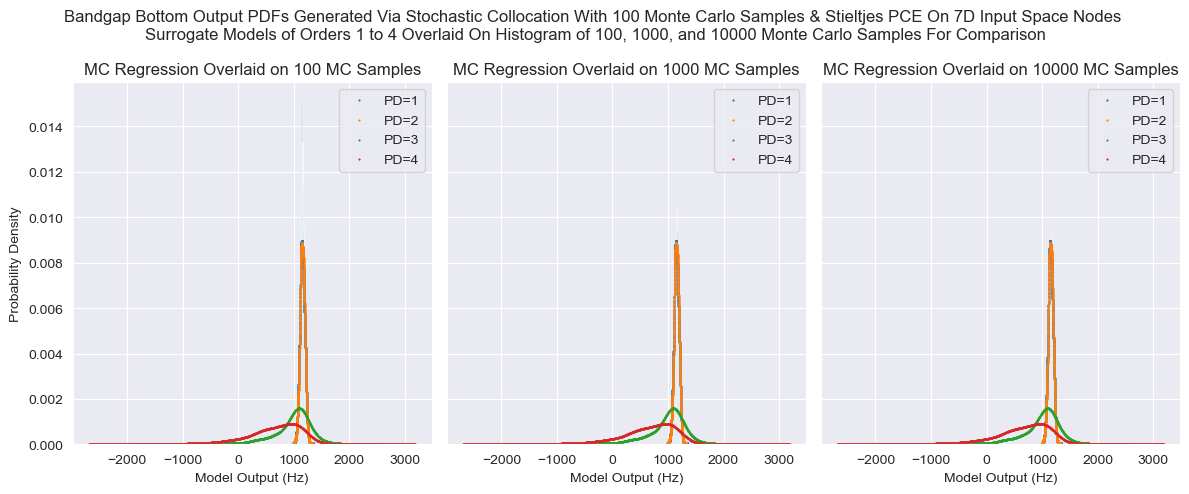

In [98]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With '+str(N_MC2)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With 1000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

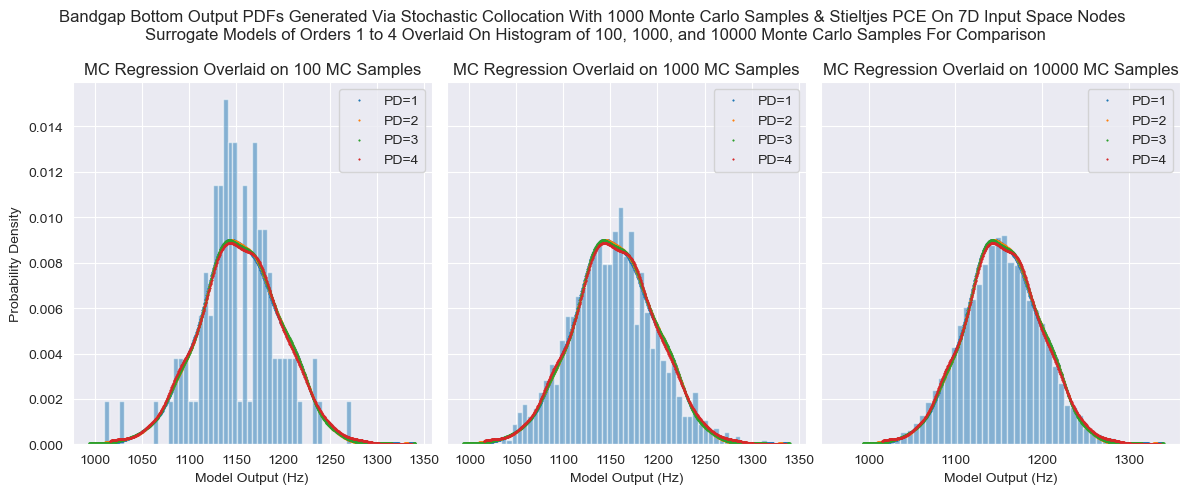

In [99]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With '+str(N_MC3)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With 10000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

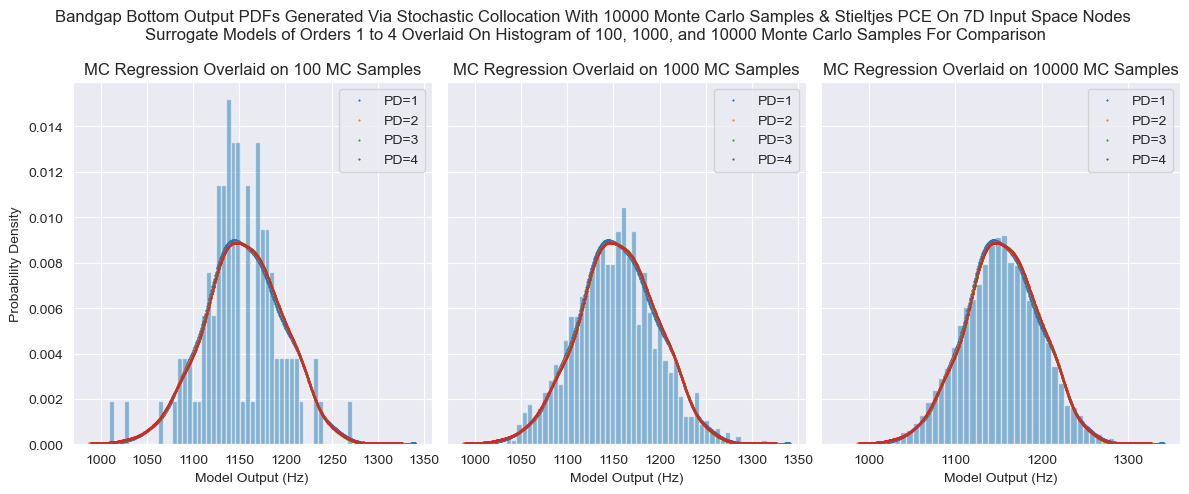

In [100]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs Generated Via Stochastic Collocation With '+str(N_MC4)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Center

In [101]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgc = {}
for n in set_N:
    print(n)
    r_surrogates_bgc[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n],
            evals=bg_center_MC_sets[n],
        )
        r_surrogates_bgc[n][degree] = polynomial_approximation

100
1000
10000


In [102]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgc[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), 1000))

Text(0.5, 0.98, 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With 100 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

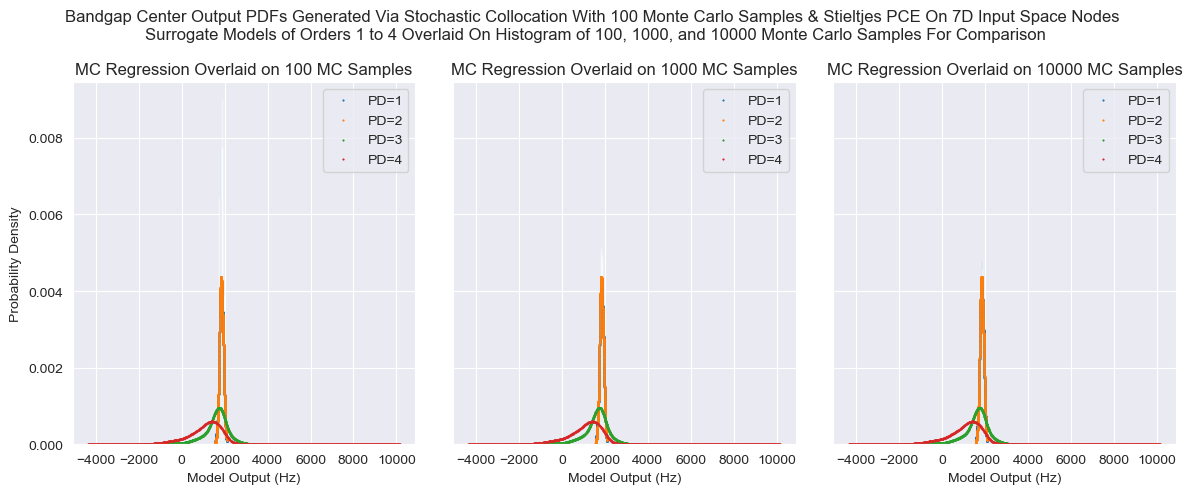

In [103]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), 1000), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With '+str(N_MC2)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With 1000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

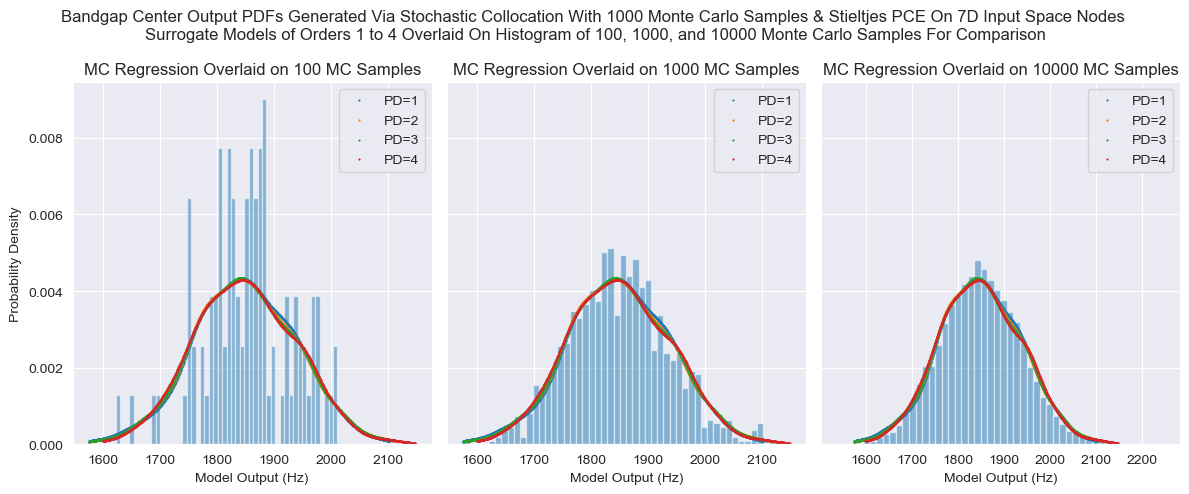

In [104]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), 1000), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With '+str(N_MC3)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With 10000 Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

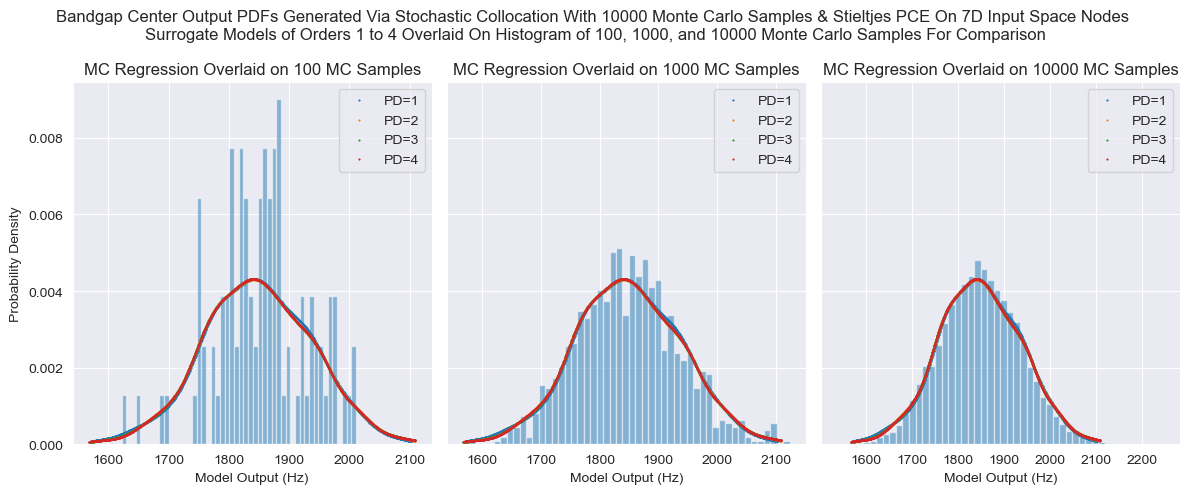

In [105]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), 1000), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs Generated Via Stochastic Collocation With '+str(N_MC4)+' Monte Carlo Samples & Stieltjes PCE On 7D Input Space Nodes \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

2D HISTOGRAMS (BANDGAP SIZE & CENTER)

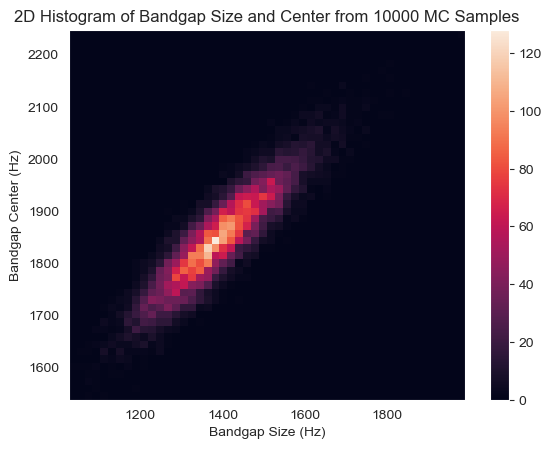

In [69]:
fig = plt.subplots()
plt.hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50))

plt.colorbar()
plt.xlabel('Bandgap Size (Hz)')
plt.ylabel('Bandgap Center (Hz)')
plt.title('2D Histogram of Bandgap Size and Center from 10000 MC Samples')
plt.show()

In [70]:
print(degrees)
print(MC_degrees[1000])
intersection_degrees = np.intersect1d(degrees, MC_degrees[1000])
print(intersection_degrees)

[1, 2]
[1 2 3 4]
[1 2]


In [71]:
#joint_output_dist = cp.J(bg_size_dist, bg_center_dist)
N_test_4 = 10**4
joint_test_4 = joint_dist.sample(N_test_4)
surrogate_outputs_q_bgs = {}
surrogate_outputs_q_bgc = {}
surrogate_outputs_r_bgs = {}
surrogate_outputs_r_bgc = {}

for degree in intersection_degrees:
    surrogate_model_q_bgs = q_surrogates_bgs[degree]
    surrogate_outputs_q_bgs[degree] = surrogate_model_q_bgs(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_q_bgc = q_surrogates_bgc[degree]
    surrogate_outputs_q_bgc[degree] = surrogate_model_q_bgc(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_r_bgs = r_surrogates_bgs[N_MC3][degree]
    surrogate_outputs_r_bgs[degree] = surrogate_model_r_bgs(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_r_bgc = r_surrogates_bgc[N_MC3][degree]
    surrogate_outputs_r_bgc[degree] = surrogate_model_r_bgc(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

print(surrogate_outputs_q_bgs.keys())

dict_keys([1, 2])


(10000,)


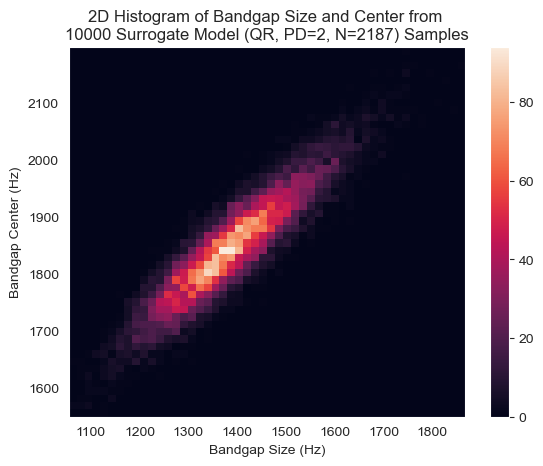

In [72]:
pd = 2
fig = plt.subplots()
plt.hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50))
print(surrogate_outputs_q_bgs[pd].flatten().shape)
plt.colorbar()
plt.xlabel('Bandgap Size (Hz)')
plt.ylabel('Bandgap Center (Hz)')
plt.title('2D Histogram of Bandgap Size and Center from \n10000 Surrogate Model (QR, PD=2, N='+str(len(bg_size_sample_sets[2].flatten()))+') Samples')
plt.show()

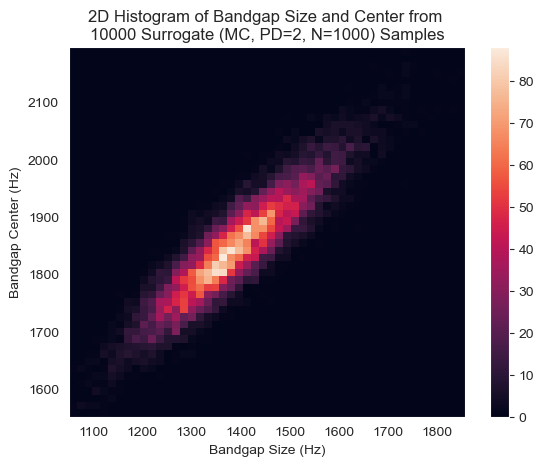

In [73]:
pd = 2
fig = plt.subplots()
plt.hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50))

plt.colorbar()
plt.xlabel('Bandgap Size (Hz)')
plt.ylabel('Bandgap Center (Hz)')
plt.title('2D Histogram of Bandgap Size and Center from \n10000 Surrogate (MC, PD=2, N='+str(len(bg_size_MC_sets[1000].flatten()))+') Samples')
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([1025.87867135, 1045.18633269, 1064.49399403, 1083.80165536,
       1103.1093167 , 1122.41697803, 1141.72463937, 1161.0323007 ,
       1180.33996204, 1199.64762337, 1218.95528471, 1238.26294605,
       1257.57060738, 1276.87826872, 1296.18593005, 1315.49359139,
       1334.80125272, 1354.10891406, 1373.4165754 , 1392.72423673,
       1412.03189807, 1431.3395594 , 1450.64722074, 1469.95488207,
       1489.26254341, 1508.57020475, 1527.87786608, 1547.18552742,
       1566.49318875, 1585.80085009, 1605.10851142, 1624.41617276,
       1643.7238341 , 1663.03149543, 1682.33915677, 1701.6468181 ,
       1720.95447944, 1740.26214077, 1759.56980211, 1778.87746345,
       1798.18512478, 1817.49278612, 1836.80044745, 1856.10810879,
       1875.41577012

Text(0.5, 0.98, '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model')

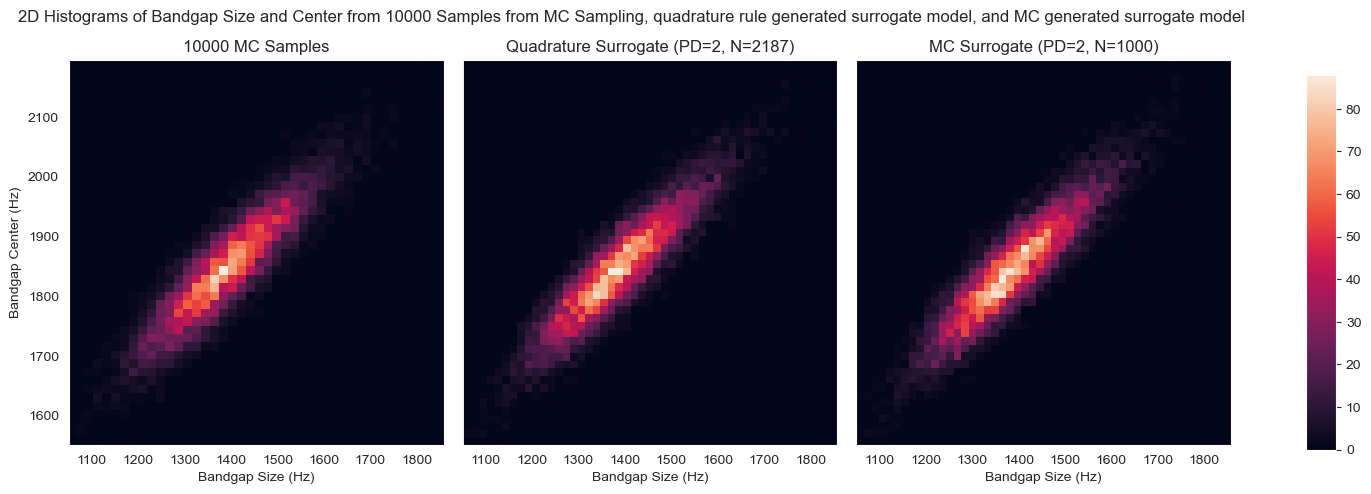

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
pd = 2
hist_mc_samples = axs[0].hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50))
hist_q_gen = axs[1].hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50))
hist_mc_gen = axs[2].hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50))

print(hist_mc_samples)
axs[0].set_xlabel("Bandgap Size (Hz)")
axs[0].set_ylabel("Bandgap Center (Hz)")
axs[0].set_title('10000 MC Samples')
#axs[0].set_aspect('equal')

axs[1].set_xlabel("Bandgap Size (Hz)")
#axs[1].set_ylabel("Bandgap Center (Hz)")
axs[1].set_title('Quadrature Surrogate (PD='+str(pd)+', N='+str(len(bg_size_sample_sets[pd].flatten()))+')')
#axs[1].set_aspect('equal')

axs[2].set_xlabel("Bandgap Size (Hz)")
#axs[2].set_ylabel("Bandgap Center (Hz)")
axs[2].set_title('MC Surrogate (PD='+str(pd)+', N='+str(len(bg_size_MC_sets[1000].flatten()))+')')
#axs[2].set_aspect('equal')

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
fig.colorbar(hist_mc_gen[3], cax=cbar_ax)
plt.subplots_adjust(wspace=0.05)

title_str = '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model'
fig.suptitle(title_str)

Text(0.5, 0.98, '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model')

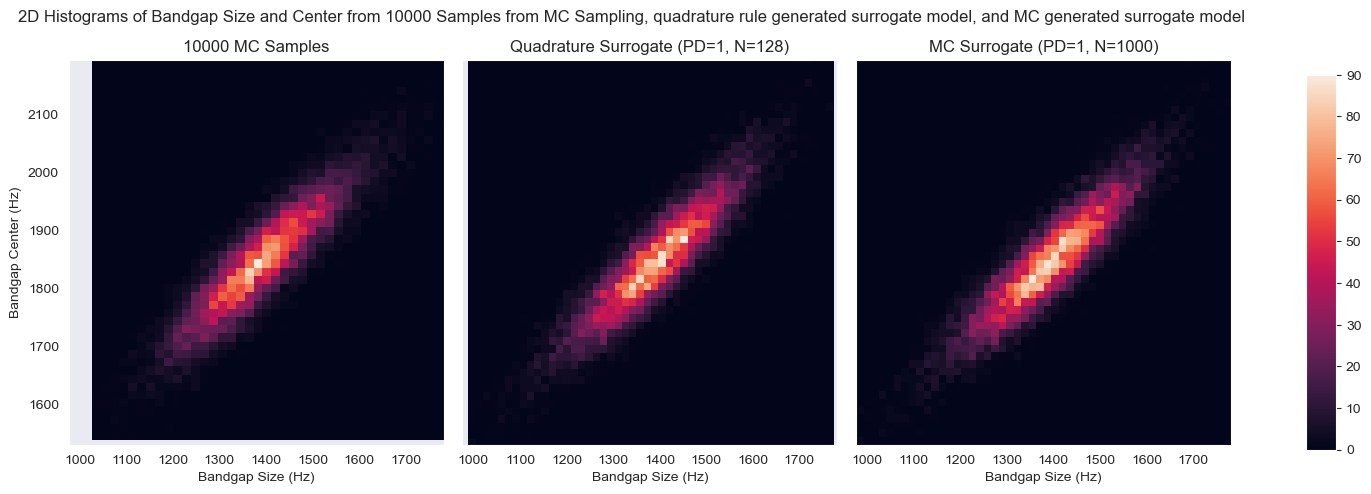

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
pd = 1
hist_mc_samples = axs[0].hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50))
hist_q_gen = axs[1].hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50))
hist_mc_gen = axs[2].hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50))

axs[0].set_xlabel("Bandgap Size (Hz)")
axs[0].set_ylabel("Bandgap Center (Hz)")
axs[0].set_title('10000 MC Samples')
#axs[0].set_aspect('equal')

axs[1].set_xlabel("Bandgap Size (Hz)")
#axs[1].set_ylabel("Bandgap Center (Hz)")
axs[1].set_title('Quadrature Surrogate (PD='+str(pd)+', N='+str(len(bg_size_sample_sets[pd].flatten()))+')')
#axs[1].set_aspect('equal')

axs[2].set_xlabel("Bandgap Size (Hz)")
#axs[2].set_ylabel("Bandgap Center (Hz)")
axs[2].set_title('MC Surrogate (PD='+str(pd)+', N='+str(len(bg_size_MC_sets[1000].flatten()))+')')
#axs[2].set_aspect('equal')

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
fig.colorbar(hist_mc_gen[3], cax=cbar_ax)
plt.subplots_adjust(wspace=0.05)

title_str = '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model'
fig.suptitle(title_str)